In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

In [2]:
# Load the data
train = pd.read_csv("C:/Users/vaibhav semwal/Desktop/train_2.csv")

In [3]:
train_flattened = pd.melt(train[list(train.columns[-50:])+['Page']], id_vars='Page', var_name='date', value_name='Visits')
train_flattened['date'] = train_flattened['date'].astype('datetime64[ns]')
train_flattened['weekend'] = ((train_flattened.date.dt.dayofweek) // 5 == 1).astype(float)

In [4]:
# Median by page
df_median = pd.DataFrame(train_flattened.groupby(['Page'])['Visits'].median())
df_median.columns = ['median']

# Average by page
df_mean = pd.DataFrame(train_flattened.groupby(['Page'])['Visits'].mean())
df_mean.columns = ['mean']

# Merging data
train_flattened = train_flattened.set_index('Page').join(df_mean).join(df_median)

In [5]:
train_flattened.reset_index(drop=False,inplace=True)

In [6]:
train_flattened['weekday'] = train_flattened['date'].apply(lambda x: x.weekday())

In [7]:
# Feature engineering with the date
train_flattened['year']=train_flattened.date.dt.year 
train_flattened['month']=train_flattened.date.dt.month 
train_flattened['day']=train_flattened.date.dt.day

In [8]:
train_flattened.head()

,Page,date,Visits,weekend,mean,median,weekday,year,month,day
0,!vote_en.wikipedia.org_all-access_all-agents,2016-11-12,2.0,1.0,2.836735,2.0,5,2016,11,12
1,!vote_en.wikipedia.org_all-access_all-agents,2016-11-13,2.0,1.0,2.836735,2.0,6,2016,11,13
2,!vote_en.wikipedia.org_all-access_all-agents,2016-11-14,4.0,0.0,2.836735,2.0,0,2016,11,14
3,!vote_en.wikipedia.org_all-access_all-agents,2016-11-15,8.0,0.0,2.836735,2.0,1,2016,11,15
4,!vote_en.wikipedia.org_all-access_all-agents,2016-11-16,3.0,0.0,2.836735,2.0,2,2016,11,16


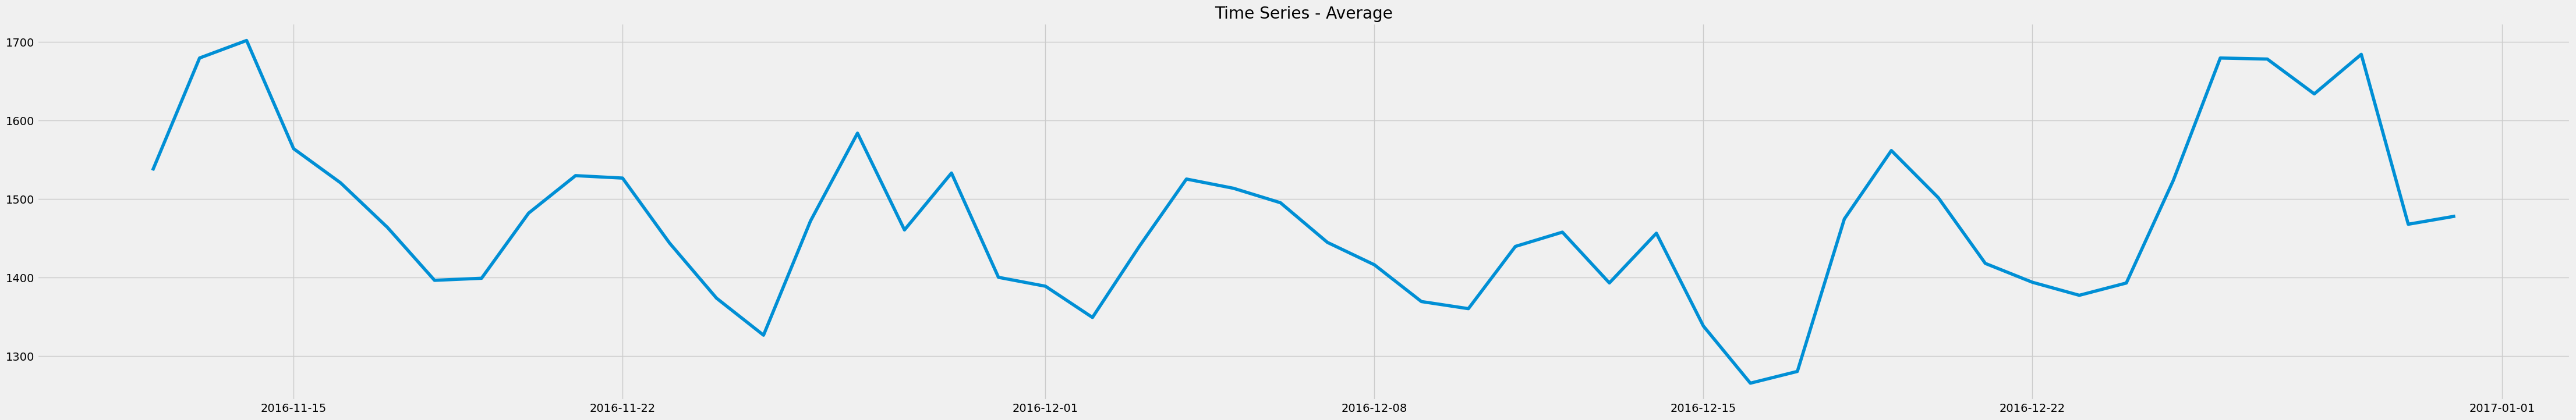

In [9]:
plt.figure(figsize=(50, 8))
mean_group = train_flattened[['Page','date','Visits']].groupby(['date'])['Visits'].mean()
plt.plot(mean_group)
plt.title('Time Series - Average')
plt.show()

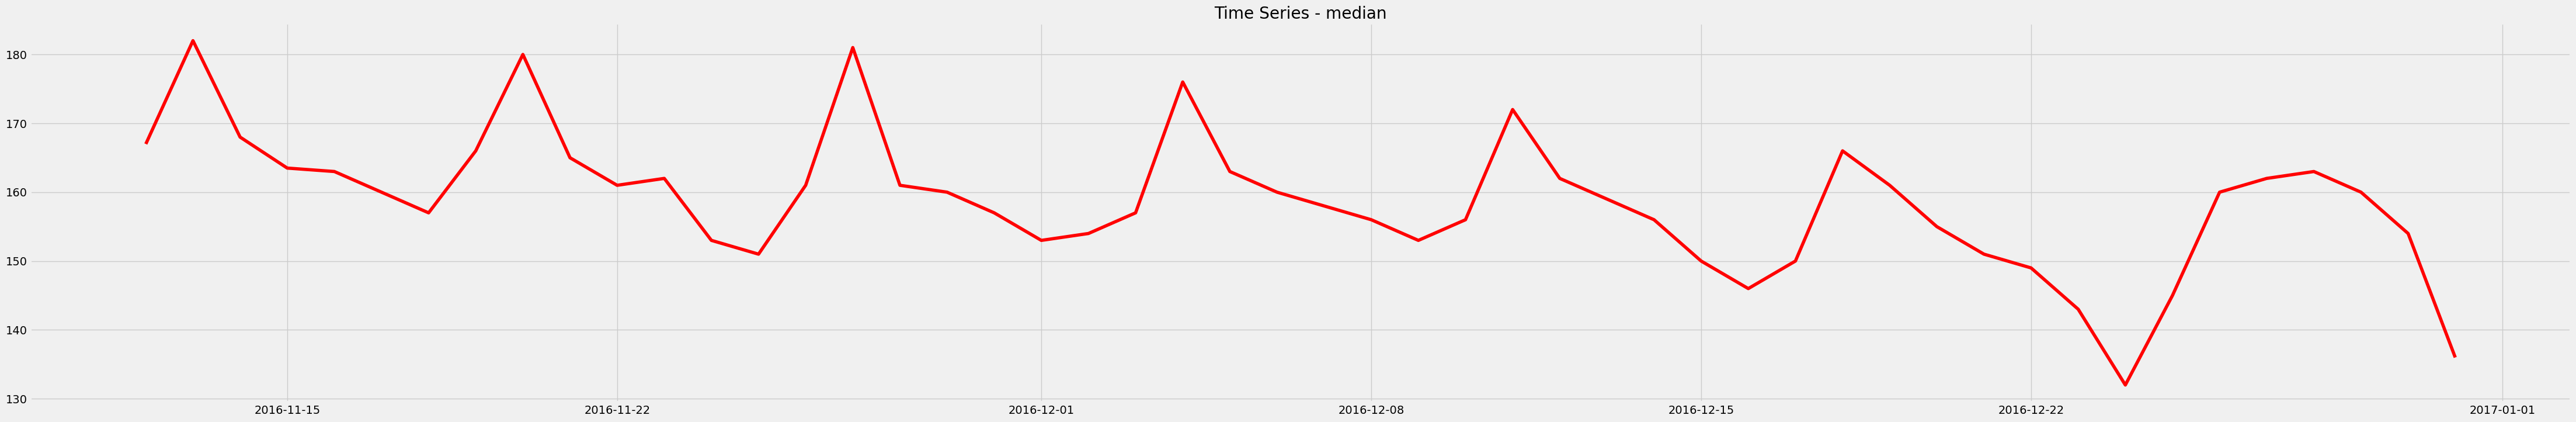

In [10]:
plt.figure(figsize=(50, 8))
median_group = train_flattened[['Page','date','Visits']].groupby(['date'])['Visits'].median()
plt.plot(median_group, color = 'r')
plt.title('Time Series - median')
plt.show()

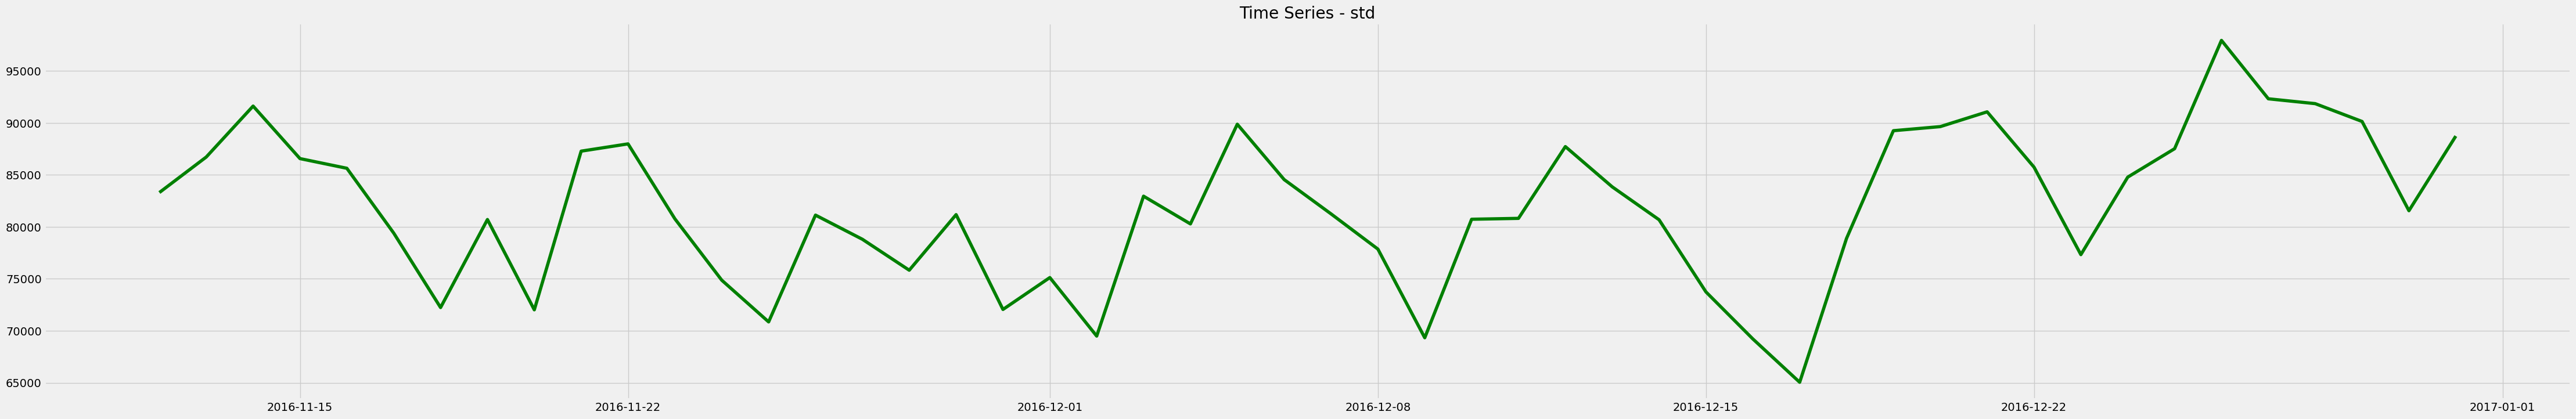

In [11]:
plt.figure(figsize=(50, 8))
std_group = train_flattened[['Page','date','Visits']].groupby(['date'])['Visits'].std()
plt.plot(std_group, color = 'g')
plt.title('Time Series - std')
plt.show()

In [12]:
# For the next graphics
train_flattened['month_num'] = train_flattened['month']
train_flattened['month'].replace('11','11 - November',inplace=True)
train_flattened['month'].replace('12','12 - December',inplace=True)

train_flattened['weekday_num'] = train_flattened['weekday']
train_flattened['weekday'].replace(0,'01 - Monday',inplace=True)
train_flattened['weekday'].replace(1,'02 - Tuesday',inplace=True)
train_flattened['weekday'].replace(2,'03 - Wednesday',inplace=True)
train_flattened['weekday'].replace(3,'04 - Thursday',inplace=True)
train_flattened['weekday'].replace(4,'05 - Friday',inplace=True)
train_flattened['weekday'].replace(5,'06 - Saturday',inplace=True)
train_flattened['weekday'].replace(6,'07 - Sunday',inplace=True)

In [13]:
train_group = train_flattened.groupby(["month", "weekday"])['Visits'].mean().reset_index()
train_group = train_group.pivot('weekday','month','Visits')
train_group.sort_index(inplace=True)

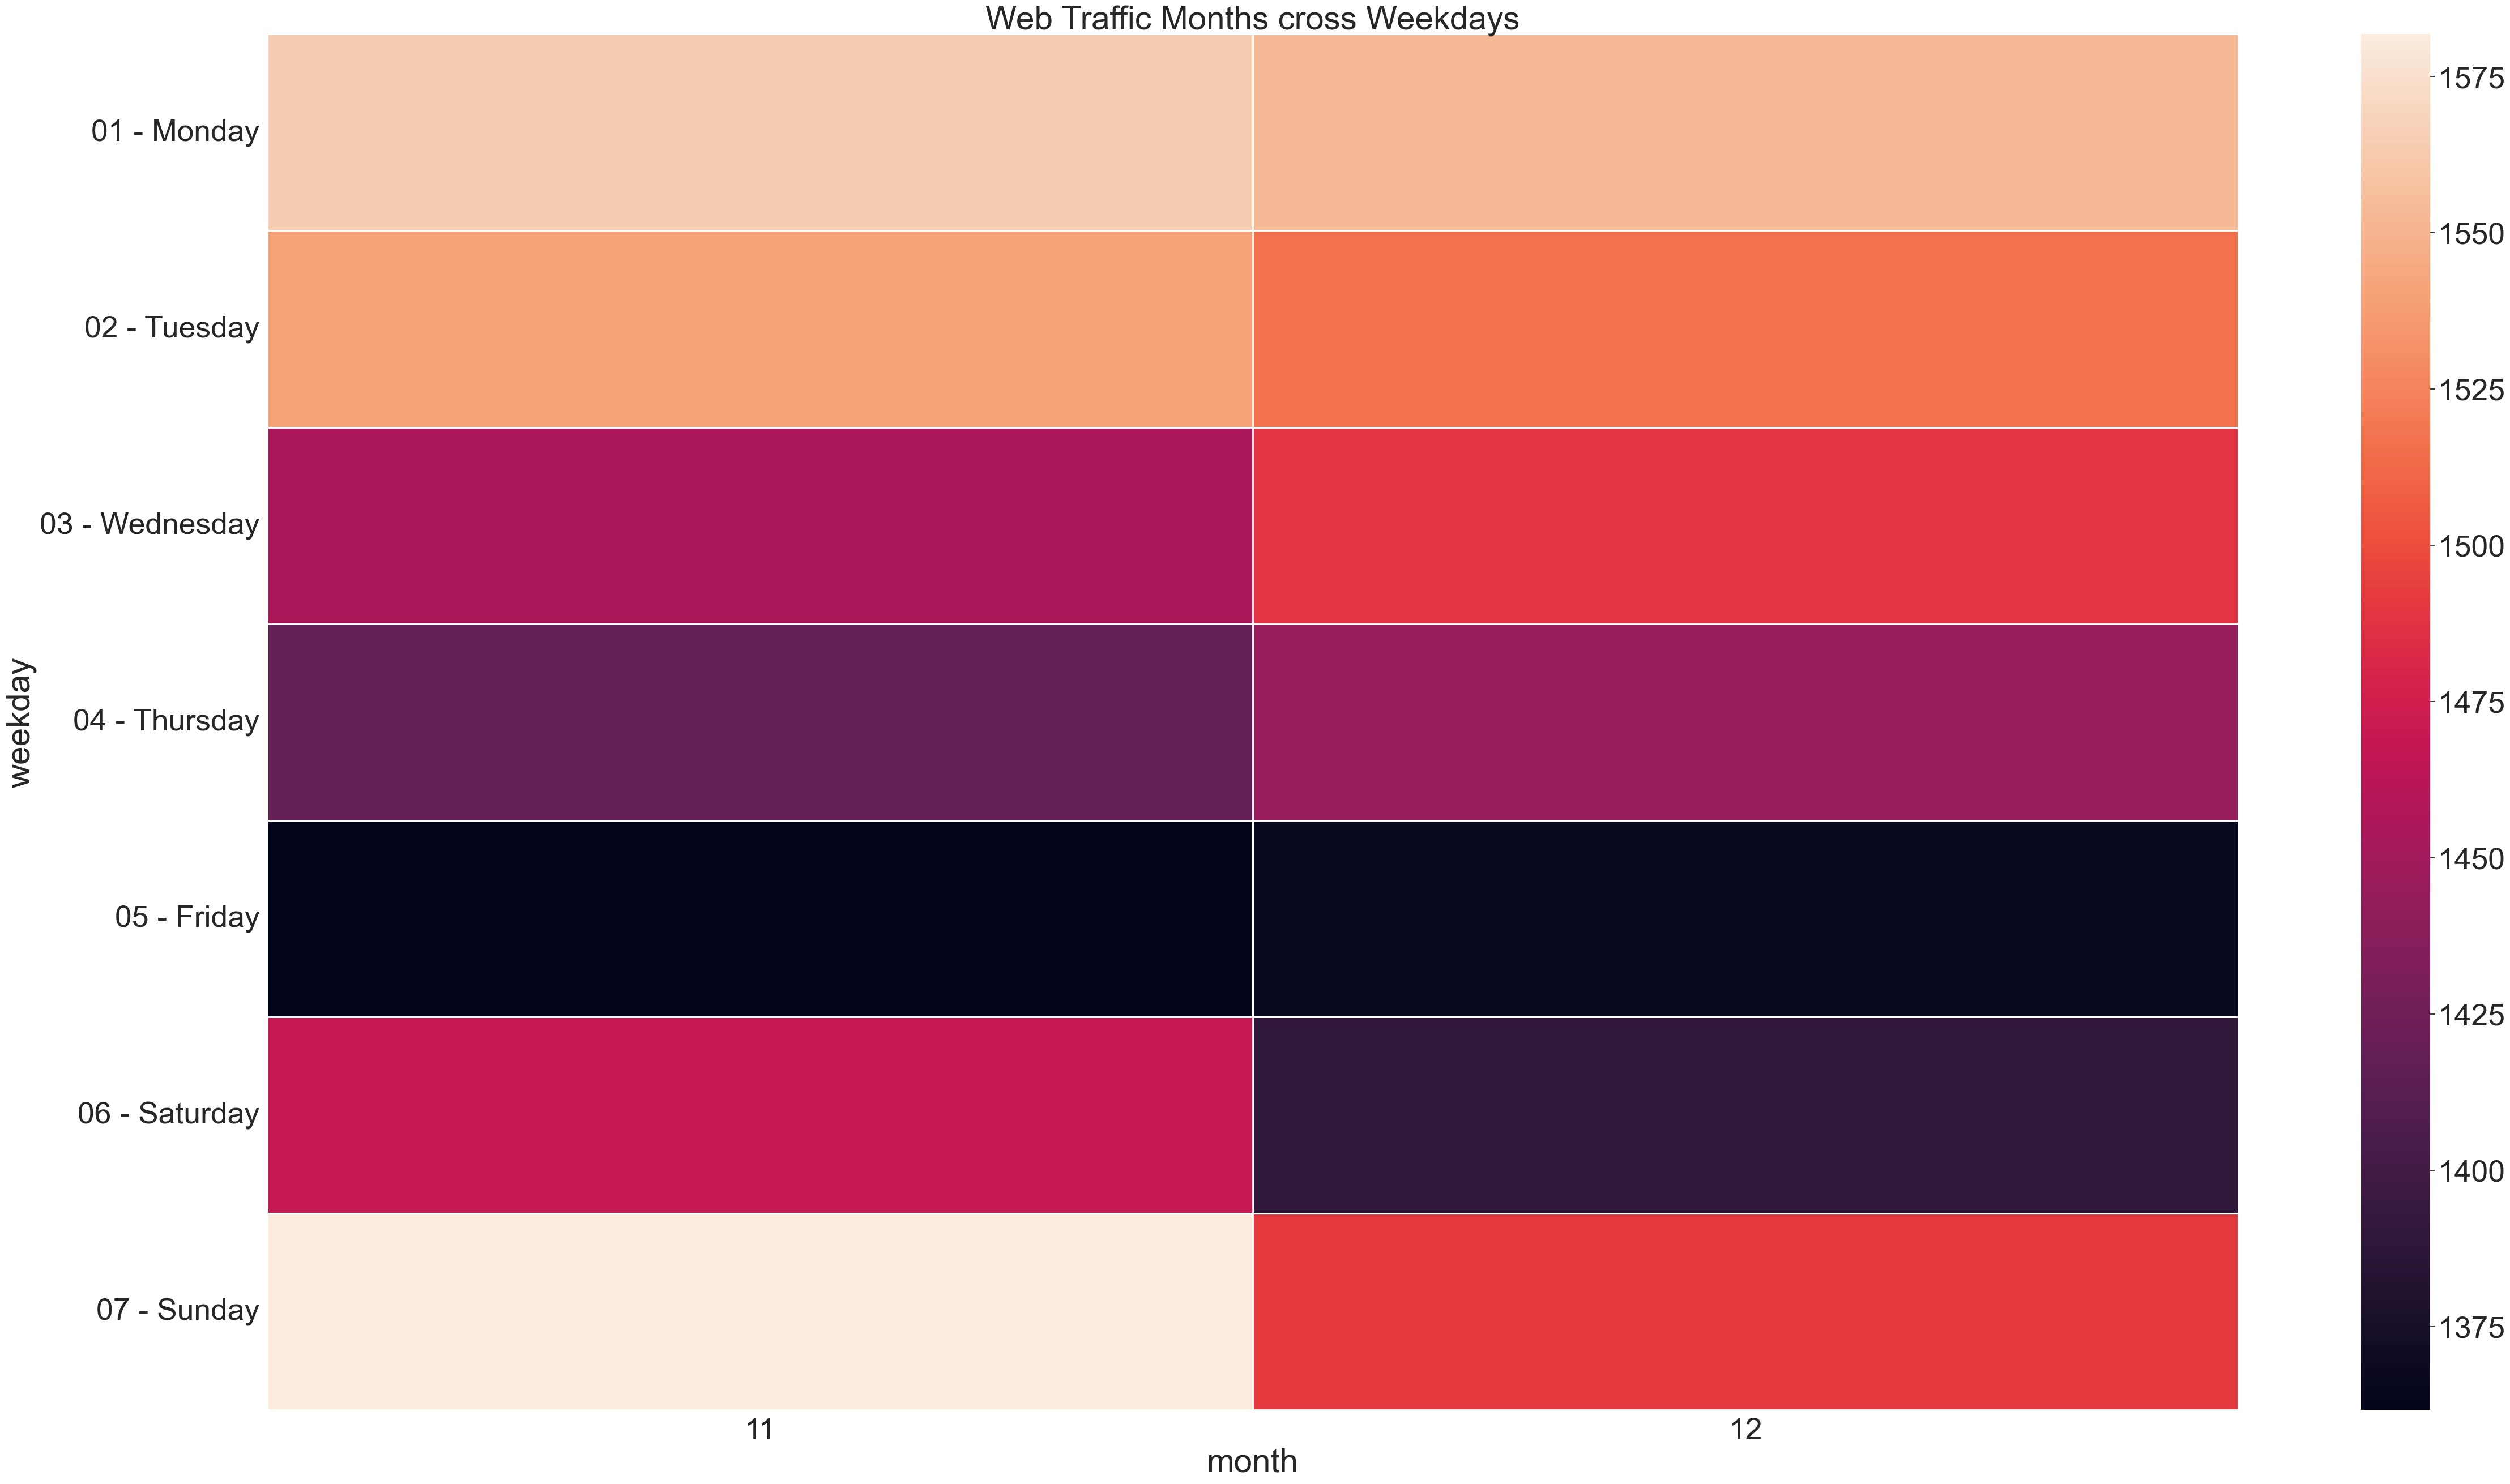

In [14]:
sns.set(font_scale=3.5) 

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(50, 30))
sns.heatmap(train_group, annot=False, ax=ax, fmt="d", linewidths=2)
plt.title('Web Traffic Months cross Weekdays')
plt.show()

In [15]:
train_day = train_flattened.groupby(["month", "day"])['Visits'].mean().reset_index()
train_day = train_day.pivot('day','month','Visits')
train_day.sort_index(inplace=True)
train_day.dropna(inplace=True)

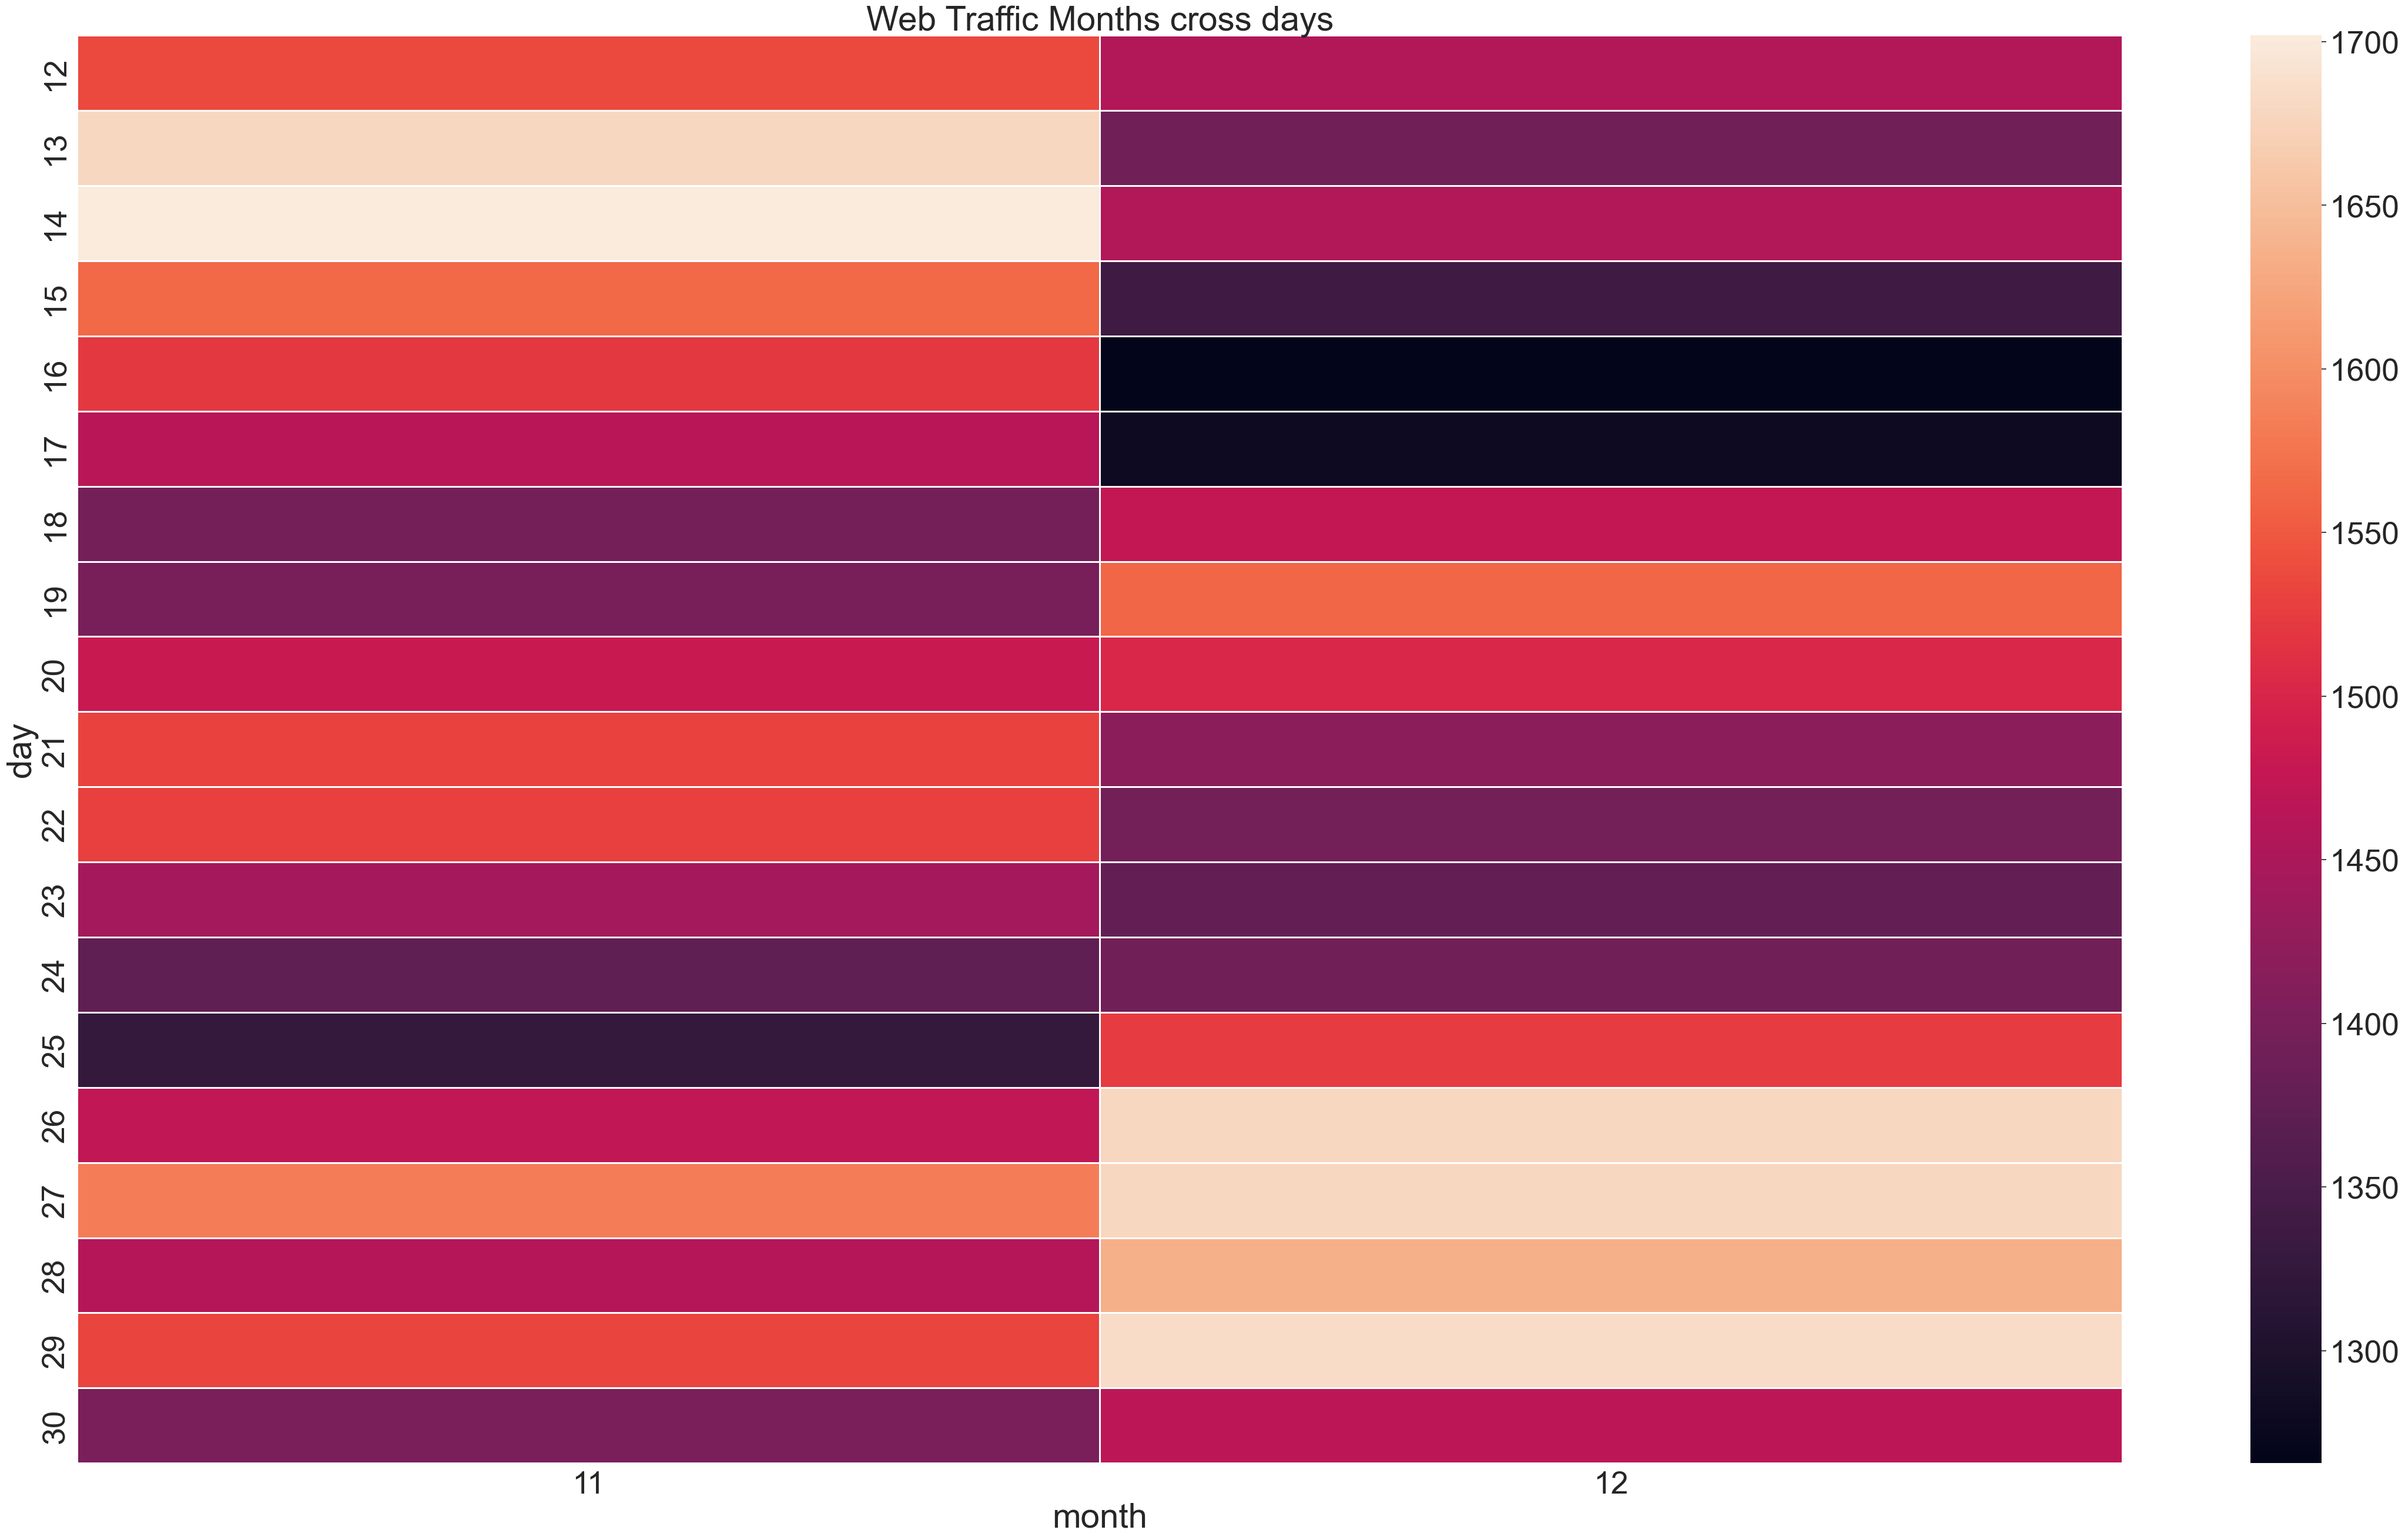

In [16]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(50, 30))
sns.heatmap(train_day, annot=False, ax=ax, fmt="d", linewidths=2)
plt.title('Web Traffic Months cross days')
plt.show()

In [17]:
times_series_means =  pd.DataFrame(mean_group).reset_index(drop=False)
times_series_means['weekday'] = times_series_means['date'].apply(lambda x: x.weekday())
times_series_means['Date_str'] = times_series_means['date'].apply(lambda x: str(x))
times_series_means[['year','month','day']] = pd.DataFrame(times_series_means['Date_str'].str.split('-',2).tolist(), columns = ['year','month','day'])
date_staging = pd.DataFrame(times_series_means['day'].str.split(' ',2).tolist(), columns = ['day','other'])
times_series_means['day'] = date_staging['day']*1
times_series_means.drop('Date_str',axis = 1, inplace =True)
times_series_means.head()

,date,Visits,weekday,year,month,day
0,2016-11-12,1536.471757,5,2016,11,12
1,2016-11-13,1679.630589,6,2016,11,13
2,2016-11-14,1701.941831,0,2016,11,14
3,2016-11-15,1564.172228,1,2016,11,15
4,2016-11-16,1520.673959,2,2016,11,16


13:16:16 - cmdstanpy - INFO - Chain [1] start processing
13:16:16 - cmdstanpy - INFO - Chain [1] done processing


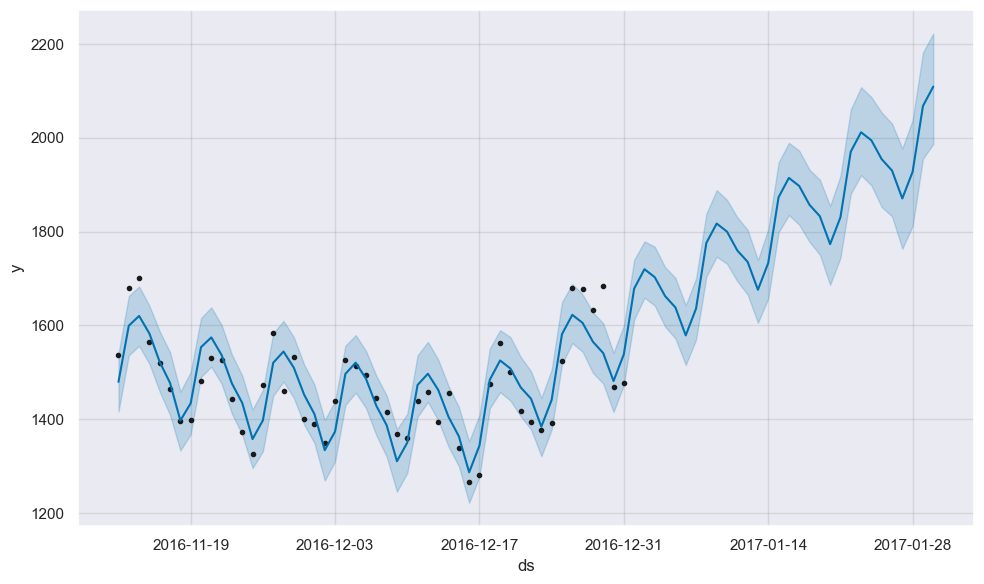

In [18]:
#using fbprophet to forcast
from prophet import Prophet
sns.set(font_scale=1) 
df_date_index = times_series_means[['date','Visits']]
df_date_index = df_date_index.set_index('date')
df_prophet = df_date_index.copy()
df_prophet.reset_index(drop=False,inplace=True)
df_prophet.columns = ['ds','y']

m = Prophet()
m.fit(df_prophet)
future = m.make_future_dataframe(periods=30,freq='D')
forecast = m.predict(future)
fig = m.plot(forecast)

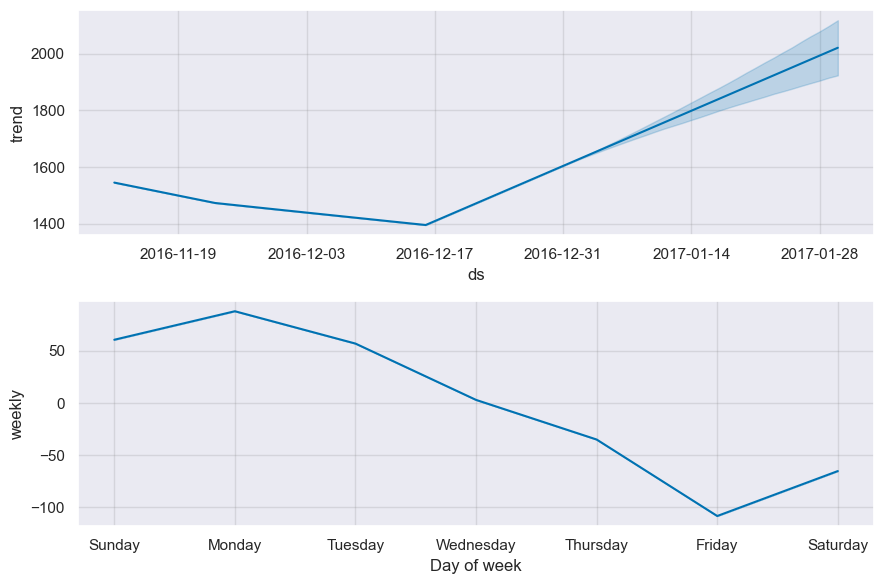

In [19]:
m.plot_components(forecast);